###  An implementation of "A graph based keyword extraction model using collective node weight"

In [1]:
import numpy as np 
import pandas as pd 
import re
import nltk 
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
#data = pd.read_excel('IPL_Sample.xlsx')  
#comments = data.iloc[:, 9].values
data = pd.read_excel('testData.xlsx')  
comments = data.iloc[:, 0].values

In [3]:
comments

array(['Today we express our deepest gratitude to all those who have served in our armed forces. #ThankAVet https://t.co/wPk7QWpK8Z',
       'Busy day planned in New York. Will soon be making some very important decisions on the people who will be running our government!',
       'Love the fact that the small groups of protesters last night have passion for our great country. We will all come together and be proud!',
       'Just had a very open and successful presidential election. Now professional protesters, incited by the media, are protesting. Very unfair!',
       'A fantastic day in D.C. Met with President Obama for first time. Really good meeting, great chemistry. Melania liked Mrs. O a lot!',
       'Happy 241st birthday to the U.S. Marine Corps! Thank you for your service!! https://t.co/Lz2dhrXzo4',
       'Such a beautiful and important evening! The forgotten man and woman will never be forgotten again. We will all come together as never before',
       'Watching the returns

In [4]:
processed_features = []
for sentence in range(0, len(comments)): 
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(comments[sentence]))
    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 
    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)
    # Removing prefixed 'b'
    #processed_feature = re.sub(r'^b\s+', '', processed_feature)
    # Converting to Lowercase
    processed_feature = processed_feature.lower()
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(processed_feature)  
    filtered_sentence = [w for w in word_tokens if not w in stop_words]  
    filtered_sentence = []  
    for w in word_tokens:  
        if w not in stop_words:  
            filtered_sentence.append(w)  
        
    processed_features.append(filtered_sentence)

In [5]:
#processed_features

In [6]:
G = nx.Graph()
G.clear()
for k in range(len(processed_features)):
    filtered_sentence = processed_features[k]
    for i in range(len(filtered_sentence)):
        if filtered_sentence[i] not in G:
            G.add_node(filtered_sentence[i], Wjk = 0, NE_Rank = 1, degree_centrality = 0, weight = 0, normal_weight = 0, freq= 1, DC = 0, SC = 0, Neighimp = 0, Fi = 0, Li = 0, CountAsFirst = 0, CountAsLast = 0)
        else:
            G.nodes[filtered_sentence[i]]["freq"] = G.nodes[filtered_sentence[i]]["freq"] + 1
        
        if i == 0:   
            G.nodes[filtered_sentence[i]]["CountAsFirst"] = G.nodes[filtered_sentence[i]]["CountAsFirst"] + 1
        if i == len(filtered_sentence) - 1:
            G.nodes[filtered_sentence[i]]["CountAsLast"] = G.nodes[filtered_sentence[i]]["CountAsLast"] + 1

    for i in range(len(filtered_sentence) - 1):
        G.add_edge(filtered_sentence[i], filtered_sentence[i+1])
        try:
            G[filtered_sentence[i]][filtered_sentence[i+1]]['freq'] = G[filtered_sentence[i]][filtered_sentence[i+1]]['freq'] + 1
        except:
            G[filtered_sentence[i]][filtered_sentence[i+1]]['freq'] = 1


## Wc(i, j)

In [7]:
for currentEdge in G.edges:
    freq_ij = G[currentEdge[0]][currentEdge[1]]['freq']
    freq_i = G.nodes[currentEdge[0]]["freq"]
    freq_j = G.nodes[currentEdge[1]]["freq"]
    G[currentEdge[0]][currentEdge[1]]['weight'] = freq_ij /(freq_i + freq_j - freq_ij)

## Remove AOF

In [8]:

AOF = 0
for currentNode in G.nodes:
    AOF = AOF + G.nodes[currentNode]['freq']

AOF = AOF / len(G)
print("AOF = " + str(AOF))

print("Len of Graph before AOF removing = " + str(len(G)))
removeList = []
for currentNode in G.nodes:
    if(G.nodes[currentNode]['freq'] < AOF):
        removeList.append(currentNode)
        
for i in range(len(removeList)):
        G.remove_node(removeList[i])
        
print("Len of Graph after AOF removing = " + str(len(G)))



AOF = 2.785128205128205
Len of Graph before AOF removing = 1950
Len of Graph after AOF removing = 381


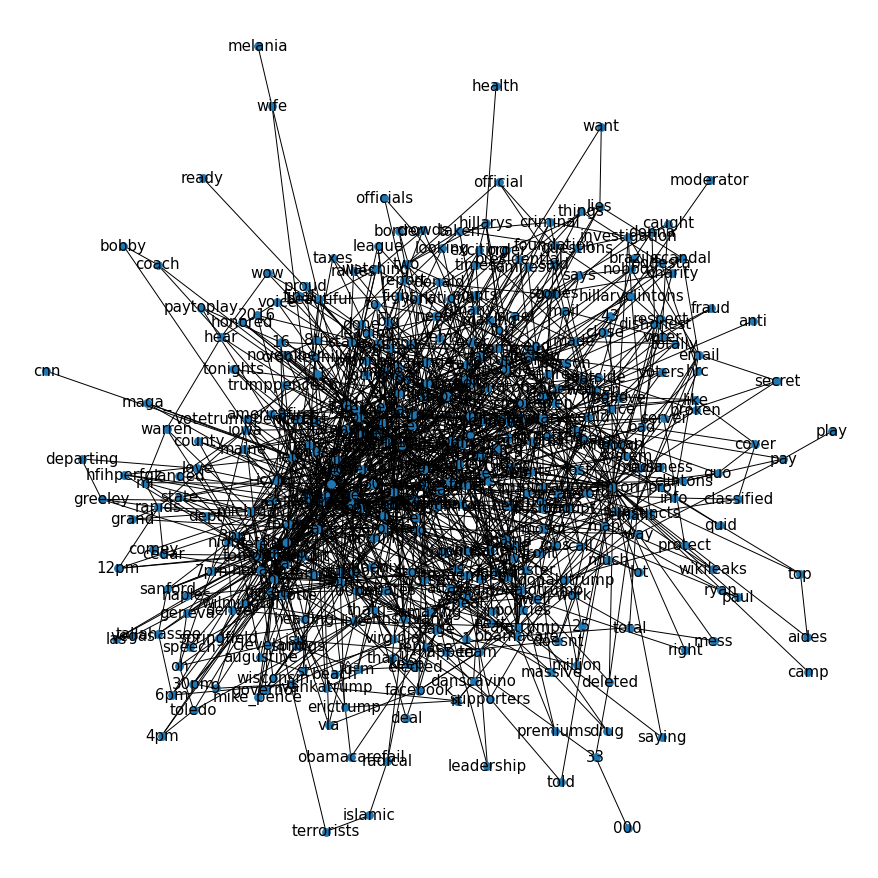

In [9]:
plt.figure(figsize=(12,12)) 
nx.draw(G,with_labels=True, node_size=60,font_size=15)


## Extract Central Node

In [10]:
maxDegree = 0
centralNode = []
for currentNode in G.nodes:
    if(G.degree[currentNode] > maxDegree):
        maxDegree = G.degree[currentNode]
        centralNode = currentNode
        
print("Central Node is: " + centralNode)
print("Max Degree is: " +  str(maxDegree))

Central Node is: https
Max Degree is: 66


## Calculate Distance of nodes from central node

In [11]:
sp = dict(nx.all_pairs_dijkstra_path_length(G))

In [12]:
for currentElement in sp:
    if currentElement == centralNode:
        DC = 1
    else:
        DC = 1 / sp[currentElement][centralNode]
    #print(DC)
    G.nodes[currentElement]["DC"] = DC

## Selectivity Centrality

In [13]:
for currentNode in G:
    Sv = len(G.edges(currentNode)) #strength of a vertex
    G.nodes[currentElement]["SC"] = Sv / G.degree(currentNode)

## Importance of neighboring nodes (Neigh_Imp)

In [14]:
for currentNode in G:
    neighbors = G.neighbors(currentNode);
    sumOfNeighbors_Sv = 0# sum Neighbors strength
    lenCounter = 0
    for currentNieghbor in neighbors:
        Sv = len(G.edges(currentNieghbor)) #strength of a vertex
        sumOfNeighbors_Sv = sumOfNeighbors_Sv + Sv
        lenCounter = lenCounter + 1

    try:
        G.nodes[currentElement]["Neighimp"] = sumOfNeighbors_Sv / lenCounter
    except:
        G.nodes[currentElement]["Neighimp"] = 0

## Position of a node

In [15]:
for currentNode in G.nodes:
    G.nodes[currentNode]["Fi"] = G.nodes[currentNode]["CountAsFirst"] / G.nodes[currentNode]["freq"]
    G.nodes[currentNode]["Li"] = G.nodes[currentNode]["CountAsLast"] / G.nodes[currentNode]["freq"]


## weight of node

In [16]:
for currentNode in G.nodes:
    DC = G.nodes[currentNode]["DC"]
    SC = G.nodes[currentNode]["SC"]
    Neighimp = G.nodes[currentNode]["Neighimp"]
    Fi = G.nodes[currentNode]["Fi"]
    Li = G.nodes[currentNode]["Li"]
    freq = G.nodes[currentNode]["freq"]
    G.nodes[currentNode]["weight"] = DC + SC + Neighimp + Fi + Li + freq

## normalization - Finalweight

In [17]:
import math
minWeight = math.inf
maxWeight = -math.inf
for currentNode in G.nodes:
    if G.nodes[currentNode]["weight"] < minWeight:
        minWeight = G.nodes[currentNode]["weight"]
    if G.nodes[currentNode]["weight"] > maxWeight:
        maxWeight = G.nodes[currentNode]["weight"]
        

for currentNode in G.nodes:
    G.nodes[currentNode]["normal_weight"] = (G.nodes[currentNode]["weight"] - minWeight) / (maxWeight - minWeight)
    

## Calculate Wjk - it is used for NE Rank

In [18]:
for currentNode in G.nodes:
    neighborsOfCurrentNode = G.neighbors(currentNode)
    for currentNeighbor in neighborsOfCurrentNode:
        G.nodes[currentNode]["Wjk"] = G.nodes[currentNode]["Wjk"] + G[currentNode][currentNeighbor]["weight"]

## Calculate the NE rank

In [19]:
d = 0.85 # From Paper
for currentNode in G.nodes:
    W_vi = G.nodes[currentNode]["normal_weight"];
    #G.nodes[currentNode]["NE_Rank"] = (1-d)*W_vi + d*W_vi + G.nodes[currentNode]["Wjk"] 
    neighborsOfCurrentNode = G.neighbors(currentNode)
    tmp = 0
    for currentNeighbor in neighborsOfCurrentNode:
        tmp = tmp + ((G[currentNode][currentNeighbor]["weight"] / G.nodes[currentNeighbor]["Wjk"]) * G.nodes[currentNeighbor]["NE_Rank"])
        
    G.nodes[currentNode]["NE_Rank"] = (1-d)*W_vi + d*W_vi + tmp


## degree_centrality

In [20]:
for currentNode in G.nodes:
    G.nodes[currentNode]["degree_centrality"] = len(list(G.neighbors(currentNode)))

In [21]:
sortedList = list(G.nodes)
for item_I in sortedList:
    for item_J in sortedList:
        if G.nodes[item_I]["NE_Rank"] == G.nodes[item_J]["NE_Rank"]:
            if G.nodes[item_I]["degree_centrality"] == G.nodes[item_J]["degree_centrality"]:
                a = sortedList.index(item_I)
                b = sortedList.index(item_J)
                sortedList[b], sortedList[a] = sortedList[a], sortedList[b]
        elif G.nodes[item_I]["NE_Rank"] < G.nodes[item_J]["NE_Rank"]:
                a = sortedList.index(item_I)
                b = sortedList.index(item_J)
                sortedList[b], sortedList[a] = sortedList[a], sortedList[b]

In [22]:
print(sortedList)

['let', 'vote', '8th', 'happen', 'bigleaguetruth', 'iowa', 'respect', 'crowd', 'watching', 'leading', 'happened', 'doesnt', 'rigged', 'report', 'together', 'dishonest', 'next', 'support', 'ever', 'tonight', 'house', 'ryan', 'replace', 'never', 'pay', 'danscavino', 'stories', '7pm', 'scandal', 'tallahassee', 'toledo', 'days', 'wants', 'clinton', 'today', 'tampa', 'trump', 'would', '_', 'thank', 'classified', 'office', 'women', 'front', 'draintheswamp', 'done', 'mr', 'c', 'supporters', 'system', 'morning', 'disaster', 'massive', 'teamtrump', 'american', '3pm', 'order', 'political', 'america', 'see', 'campaign', 'times', 'bill', '100', 'fraud', 'hillarys', 'im', 'mike_pence', 'nobody', 'team', '30', 'radical', 'mess', 'lets', 'poll', 'work', 'voters', 'media', 'big', '25', 'govt', 'history', 'taken', 'voice', 'us', 'evening', 'rallies', 'dept', 'believe', 'outside', 'repeal', 'page', 'run', '16', 'forgotten', 'geneva', 'mosul', 'save', 'springs', 'carolina', 'totally', 'coach', 'investiga

In [23]:
NE_Rank_List = []
for item in sortedList:
    NE_Rank_List.append(G.nodes[item]["NE_Rank"])
    
degree_centrality_List = []
for item in sortedList:
    degree_centrality_List.append(G.nodes[item]["degree_centrality"])
    
weight_List = []
for item in sortedList:
    weight_List.append(G.nodes[item]["weight"])

In [24]:
data_tuples = list(zip(sortedList, NE_Rank_List, degree_centrality_List, weight_List))
data_tuples

[('let', 1.345354476238627, 7, 23.06145799280811),
 ('vote', 2.371506977936737, 28, 246.02500000000003),
 ('8th', 1.3432298194158705, 4, 28.557461282385297),
 ('happen', 1.2475086748222501, 4, 8.73067331670823),
 ('bigleaguetruth', 1.9065559066840942, 15, 108.9448275862069),
 ('iowa', 1.337994461101615, 8, 67.11568627450981),
 ('respect', 1.1644958096484372, 4, 21.117359413202937),
 ('crowd', 1.8713959488186165, 8, 29.392434005404283),
 ('watching', 2.1891587124923655, 6, 383.6),
 ('leading', 1.0445712323470233, 4, 23.1131498470948),
 ('happened', 1.3373002546130945, 5, 25.457545435005848),
 ('doesnt', 0.9268661537079046, 3, 6.298134144704461),
 ('rigged', 2.5850862709172584, 8, 393.1),
 ('report', 1.3350806301405542, 4, 9.592233419066492),
 ('together', 2.026341124084306, 11, 58.879630483631246),
 ('dishonest', 1.3331515003967398, 6, 62.09325396825396),
 ('next', 1.183831337311054, 4, 61.879684418145956),
 ('support', 1.9165382659073424, 11, 46.54328506546787),
 ('ever', 1.84566628379